# Project 3: Feature and Regressor Selection

## Overview

In this notebook, we will look at the process used to find the best feature-regressor combination out of the 4 features:(CNT,ANF,GO,Test) and 3 regressors:(GP,ET,RF). The material features (CNT, ANF, and GO) are features whose values represent the weight percents of Carbon Nanotubes, Aramid Nanofibers, and Graphene Oxide in the composite electrode, respectively. The Test feature can be either SR (Scan Rate) or CD (Current Density) and the value indicates the experimental conditions by which the capacitance was measured. The regressors (GP, ET, and RF) represent Gaussian Process, ExtraTrees, and Random Forest regressors, respectively. An exhaustive search of the 45 possible feature-regressor combinations is performed and the resulting error of each combination is analyzed using the leave-one-out method. The results of these analyses are used to find the best feature-regressor combination. Details of the methodology are listed below throughout the code.

#### ATTENTION
If you are having trouble with the notebook because of package dependencies, please refer to the text file "pip_freeze.txt" for a complete list of the python packages installed in the environment used to create this notebook.

In [1]:
import numpy as np
import sklearn as skl
#import skopt as skopt
import matplotlib.pyplot as plt
%matplotlib inline
import random
#import os
import csv
import itertools
import optimal_experiment.experiment.samples as a_samples
import optimal_experiment.experiment.optimizer as a_opt
import copy
import pickle
import seaborn as sns
import pandas as pd

# GENERAL VARIABLE CREATION
observ_tag = 'utility'
feat_columns = [0,1,2,4]
output_cols = [3,5,6,7,8]
regressor_ =  ["GP", "ET", "RF"]

# SETUP BASE VALUES FOR CD DATA SET
filename_CD = 'exp_data_CD_less.csv'
features_CD = ['ANF','GO','CNT','CD']
feat_range_CD = [(0.,100.),(0.,100.),(0.,100.),(0.0099,2.1)]
# specify SCAN RATE and capacitance for GRAPHENE OXIDE
C_GO_CD = {'0.01':1.,'0.05':2.,'0.1':3.,'0.2':222.6,'0.5':207.3,'1':195.4,'2':187.1}

# SETUP BASE VALUES FOR SR DATA SET
filename_SR = 'exp_data_SR.csv'
features_SR = ['ANF','GO','CNT','SR']
feat_range_SR = [(0.,100.),(0.,100.),(0.,100.),(0.5,250.)]
# specify SCAN RATE and capacitance for GRAPHENE OXIDE
C_GO_SR = {'1':266.3,'5':199.1,'10':179.1,'20':159.4,'50':122.4,'100':84.7,'200':56.}

## Creating the Feature-Regressor Combinations
This definition creates a list of tuples which represents all of the possible combinations of features and regressors. The first entry in the tuple is the list of columns for each feature and the second entry is the regressor that will be used with that feature combination.

This notebook will explain the process for one feature-regressor combination and will then perform the analysis for all combinations.

In [2]:
def create_combs(feat_columns,regressor_):
    # CREATE A LIST OF ALL POSSIBLE COMBINATIONS OF INPUT PARAMETERS
    feat_combs = []
    for i in range(1, len(feat_columns)+1):
        els = [list(x) for x in itertools.combinations(feat_columns, i)]
        feat_combs.extend(els)
    # CREATE A LIST OF ALL PERMUTATIONS OF FEATURE SETS AND REGRESSORS
    combined_list=[]
    for r in itertools.product(feat_combs, regressor_): 
        combined_list.append((r[0],r[1]))
    return combined_list

combined_list = create_combs(feat_columns,regressor_)
print(combined_list)
print('')
combination_example = combined_list[27]
print(combination_example)
feets = [features_SR[feat_columns.index(x)] for x in combination_example[0]]
print(feets)
reg_ = combination_example[1]
print(reg_)

[([0], 'GP'), ([0], 'ET'), ([0], 'RF'), ([1], 'GP'), ([1], 'ET'), ([1], 'RF'), ([2], 'GP'), ([2], 'ET'), ([2], 'RF'), ([4], 'GP'), ([4], 'ET'), ([4], 'RF'), ([0, 1], 'GP'), ([0, 1], 'ET'), ([0, 1], 'RF'), ([0, 2], 'GP'), ([0, 2], 'ET'), ([0, 2], 'RF'), ([0, 4], 'GP'), ([0, 4], 'ET'), ([0, 4], 'RF'), ([1, 2], 'GP'), ([1, 2], 'ET'), ([1, 2], 'RF'), ([1, 4], 'GP'), ([1, 4], 'ET'), ([1, 4], 'RF'), ([2, 4], 'GP'), ([2, 4], 'ET'), ([2, 4], 'RF'), ([0, 1, 2], 'GP'), ([0, 1, 2], 'ET'), ([0, 1, 2], 'RF'), ([0, 1, 4], 'GP'), ([0, 1, 4], 'ET'), ([0, 1, 4], 'RF'), ([0, 2, 4], 'GP'), ([0, 2, 4], 'ET'), ([0, 2, 4], 'RF'), ([1, 2, 4], 'GP'), ([1, 2, 4], 'ET'), ([1, 2, 4], 'RF'), ([0, 1, 2, 4], 'GP'), ([0, 1, 2, 4], 'ET'), ([0, 1, 2, 4], 'RF')]

([2, 4], 'GP')
['CNT', 'SR']
GP


## Creating Samples
Now that we have all of the features sets specified we need a way to parse that specific subset of features out of the csv file. Not only that, we need to create "Sample" objects with specific attributes like features and observables. 

The function below performs this task by extracting the relevant input and output data from the appropriate columns by looping through the rows of data in the csv. The input data and labels are added to each sample as features. A 'utility' is calculated from the output values via an equation defined in another definition "calculate_utility". The form of this utility is as follows:

insert utility equation here.

This equation consists of a mechanical and electrical part, the relative importance of each is defined by the weighting coefficient "a". The performance values of each sample are normalized based on the mechanical properties of pure GO. Increases to capacitance and most mechanical properties contribute positively to the utility whereas increases to Young's Modulus contribute negatively to the overall utility. This is because of proposed target application of this supercapacitor in flexible electronics.

The "forget_samples" definition is used to remove n number of samples from a sample list. This is useful for creating an list of samples with no measurement values. This empty samples can then be populated with sample data at a later time.

In [3]:
def load_samples(filename,features,input_cols,feat_columns,
                 observ_tag='utility', a=0.5,
                 C_GO={'1':266.3,'5':199.1,'10':179.1,'20':159.4,'50':122.4,'100':84.7,'200':60.9},
                 Y_GO=3700,
                 S_GO=34.4,
                 T_GO=182.3,
                 UTS_GO=1.):
    # CREATES A LIST OF SKOPT SAMPLES BY LOADING AND PARSING FEATURE AND OUTPUT
    # COLUMNS FROM SPECIFIC COLUMNS OF A CSV FILE. ES IS THE EXPERIMENTAL SPACE
    # FOUND IN DR ARROYAVE'S MODIFICATIONS TO SKOPT SOURCE CODE.
    # OUTPUT COLUMNS WILL BE [3,5,6,7,8]
    # OUTPUT LABELS WILL BE [CAP,STR,Y,UTS,TOUGH]
    a=float(a)
    samp_list = []

    # open file
    with open(filename,'r') as file_obj:
    # create data object from file
        data_obj = csv.reader(file_obj,delimiter=',',quotechar='"')
    # get labels from header
        labels = data_obj.__next__()
    # loop through rows
        for row in data_obj:
    # create a sample for this row
            samp = a_samples.Sample()
    # add a feature and its value to the sample for each input column
            for i in input_cols:
                samp.add_feature(features[feat_columns.index(i)], float(row[i]))
    # add observable and measurement for the sample based on Utility
            samp.add_observable(observ_tag)
            U = calculate_utility(row,C_GO,S_GO,Y_GO,T_GO,UTS_GO,a)
            samp.measure_observable(observ_tag,float(U))
    # boilerplate from notebook
            samp.make_lists()
    # append sample to list of samples
            samp_list.append(samp)
    return samp_list

def forget_samples(amnesia_list,n_forget='all'):
    # STRIPS THE RESULTS OF n_forget RANDOM SAMPLES FROM A LIST OF SKOPT 
    # SAMPLES. IF NONE IS PASSED THE ENTIRE LIST IS FORGOTTEN. THIS IS USEFUL
    # FOR VALIDATION WHERE THE REGRESSOR'S PREDICTION OF THE FORGOTTEN SAMPLES 
    # CAN BE COMPARED TO THE EXPERIMENTAL VALUES.
    
    # shuffle the samples around to randomize the ones that are taken out
    random.shuffle(amnesia_list)
    # create a list of indices for the samples to be modified
    if n_forget=='all':
        amnesia = list(range(len(amnesia_list)))
    else:
        amnesia = list(range(n_forget))
    forgotten_ids = []
    # loop through the sample list and erase values of the sample measurements
    for a in amnesia:
        j = amnesia_list[a]
        forgotten_ids.append(j['id'])
        for k in j['observables']:
            l = j['observables'][k]
            l['to_measure']=True
            l['measured']=False
            l['value']=None
    return forgotten_ids

def calculate_utility(row,C_GO,S_GO,Y_GO,T_GO,UTS_GO,a):
    # calculate utility from output
    #            print(row)
    elec_props = float(row[3])/C_GO[row[4]]         
    mech_props = float(row[5])/S_GO + Y_GO/float(row[6]) + \
                 float(row[7])/UTS_GO + float(row[8])/T_GO  
    U =  a*elec_props + (1-a)*mech_props
    return U

samp_list_SR = load_samples(filename_SR,features_SR,combination_example[0],feat_columns,C_GO=C_GO_SR)

for x in samp_list_SR:
    print(x)

{'features': {'CNT': 0.0, 'SR': 1.0}, 'observables': {'utility': {'name': 'utility', 'value': 2.354046682610547, 'measured': True, 'to_measure': False, 'std': 0.0}}, 'id': 'HROSFKEBENPE'}
{'features': {'CNT': 0.0, 'SR': 5.0}, 'observables': {'utility': {'name': 'utility', 'value': 2.4183357958620113, 'measured': True, 'to_measure': False, 'std': 0.0}}, 'id': 'UVXYECSEYWUQ'}
{'features': {'CNT': 0.0, 'SR': 10.0}, 'observables': {'utility': {'name': 'utility', 'value': 2.4238331750510533, 'measured': True, 'to_measure': False, 'std': 0.0}}, 'id': 'LTBPOUHJCQNT'}
{'features': {'CNT': 0.0, 'SR': 20.0}, 'observables': {'utility': {'name': 'utility', 'value': 2.449414167984492, 'measured': True, 'to_measure': False, 'std': 0.0}}, 'id': 'DYQGWESGNXET'}
{'features': {'CNT': 0.0, 'SR': 50.0}, 'observables': {'utility': {'name': 'utility', 'value': 2.5095969613025724, 'measured': True, 'to_measure': False, 'std': 0.0}}, 'id': 'XHHXOBNQRCAN'}
{'features': {'CNT': 0.0, 'SR': 100.0}, 'observables':

## Creating Experimental Space
Now that we have a list of samples which represents all of our data with some subset of features, we should define a way to create an "experimental space" for this set of features. This definition creates an experimental space with the dimensions appropriate for the feature subset we currently have.

This is where the range of feature values can be specified and a the discrete grid of sampling points is introduced. Since the project is focused on feature selection and not exploration at this point, the grid of sample points is simply the feature values we already have data for. For exploration, more datapoints will need to be added to the experimental space.

In [4]:
def create_es(sample_list,feat_columns_subset,features,feat_range,observ_tag):
    # CREATE AN EXPERIMENTAL SPACE TO HOLD FULLY EVALUATED SAMPLE DATA
    es = a_samples.Experimental_Space()
    # add features to experimental space based on combination of features
    for x in feat_columns_subset:
        es.add_feature(features[feat_columns.index(x)],feat_range[feat_columns.index(x)])
    es.set_dimensions()
    es.transform_dimensions()
    # add samples into experimental space 'es_full'
    for i in sample_list:
        es.add_sample(i)
    # boilerplate from notebook
    es.sort_samples()
    es.set_space()
    es.make_lists(observable=observ_tag)
    es.update(observable=observ_tag)
    es.transform_dimensions()
    
    return es

es_full = create_es(samp_list_SR,combination_example[0],features_SR,feat_range_SR,observ_tag)
for x in es_full['unmeasured_samples']:
    print(x)

In [5]:
# copy the full sample list to a new list where the output values will be completely forgotten
grid_list = copy.deepcopy(samp_list_SR)
# forget output values for a all samples
forget_samples(grid_list)
# CREATE AN EXPERIMENTAL SPACE TO HOLD EMPTY SAMPLES TO EVALUATE
es = create_es(grid_list,combination_example[0],features_SR,feat_range_SR,observ_tag)
for x in es['unmeasured_samples']:
    print(x)

{'features': {'CNT': 5.0, 'SR': 10.0}, 'observables': {'utility': {'name': 'utility', 'value': None, 'measured': False, 'to_measure': True, 'std': 0.0}}, 'id': 'AQWDXUTKXBMU'}
{'features': {'CNT': 20.0, 'SR': 200.0}, 'observables': {'utility': {'name': 'utility', 'value': None, 'measured': False, 'to_measure': True, 'std': 0.0}}, 'id': 'BGODXRFCZDCM'}
{'features': {'CNT': 5.0, 'SR': 1.0}, 'observables': {'utility': {'name': 'utility', 'value': None, 'measured': False, 'to_measure': True, 'std': 0.0}}, 'id': 'BIMJKALJLMJM'}
{'features': {'CNT': 15.0, 'SR': 200.0}, 'observables': {'utility': {'name': 'utility', 'value': None, 'measured': False, 'to_measure': True, 'std': 0.0}}, 'id': 'DJFQOYUYNVDM'}
{'features': {'CNT': 0.0, 'SR': 20.0}, 'observables': {'utility': {'name': 'utility', 'value': None, 'measured': False, 'to_measure': True, 'std': 0.0}}, 'id': 'DYQGWESGNXET'}
{'features': {'CNT': 20.0, 'SR': 10.0}, 'observables': {'utility': {'name': 'utility', 'value': None, 'measured': Fal

At this point we have created two experimental spaces. One with all of the data currently measured, which is essentially used as a reference point, and another empty experimental space with a grid of potential sampling spaces that are exactly equal to the experimental data currently available. This empty grid will be passed to each regression instance where it will be filled with all but one data point with the "tell()" function.

# First Pass at Feature Selection
The code in the cell below loads all of the data available and analyzes the importance of each feature based on an F-test and a Mutual Information metric. The F-test and MI values reported next to each plot are measurements which indicate how much each feature affects the variance of the utility function. The larger values reported for the three compositional features indicates that they have a more significant effect on the performance of the material, compared to scan rate, and that each component possesses equal importance.

/home/lukejohnson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


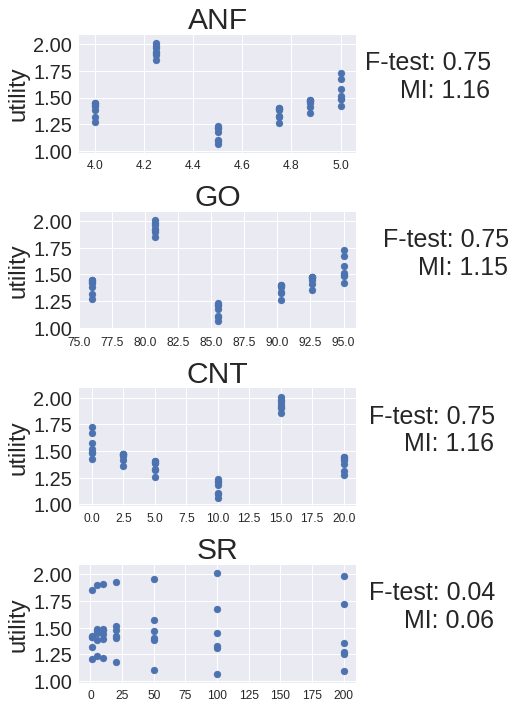

In [6]:
q = load_samples(filename_SR,features_SR,feat_columns,feat_columns,
                 observ_tag='utility', a=0.5,
                 C_GO=C_GO_SR,
                 Y_GO=5300,
                 S_GO=85.7,
                 T_GO=981.8,
                 UTS_GO=2.04)

X = [list(d['features'].values()) for d in q]
fe = [list(d['features'].keys()) for d in q]
y = [d['observables']['utility']['value'] for d in q]

F,pval = skl.feature_selection.f_regression(X,y,center=True)
Mi = skl.feature_selection.mutual_info_regression(X,y)
loc = [[5.1,1.5],[98,1.5],[22,1.5],[220,1.5]]

fig = plt.figure(figsize=[5,10])
for i in range(4):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.scatter([x[i] for x in X], y)
    for xtick in ax.get_xmajorticklabels():
        xtick.set_size(12)
    for ytick in ax.get_yticklabels():
        ytick.set_size(20)
    ax.set_ylabel('utility',fontsize=24)
    ax.text(loc[i][0],loc[i][1],"F-test: {:.2f}\n     MI: {:.2f}".format(F[i],Mi[i]),fontsize=25)
    ax.set_title(str(fe[0][i]),fontsize=30)
fig.subplots_adjust(left=0.18, bottom=0.05, right=0.95, top=0.95,
                wspace=0.1, hspace=0.5)
fig.show()


While these results above can indicate the importance of the features on the underlying response. We still need to assess the features in combination with the regressors to fully understand which feature-regressor combination(s) to choose.

# Leave-One-Out Method
Now that we have data and an experimental space to test it over, we can start testing the descriptive power of the of this specific feature-regressor combination. This descriptive ability can be determined through a leave-one-out (LOO) method which follows a process like this:
<ol>
  <p>1. remove 1 sample from the data set</p>
  <p>2. train the regressor on the remaining data</p>
  <p>3. Use the regressor to predict the value at the missing sample</p>
  <p>4. calculate the error as the absolute value of the difference between predicted and actual values</p>
  <p>5. repeat steps 1-4 for all samples within the data set</p>
</ol>

First we need to get all of the sample_id values associated with the experimental grid that we've established.

In [7]:
# create empty lists for storing the outputs of the LOO test
error_list = []
complete_list = []
summary_list = []
# perform "n_tests" LOO error approximations for these regressors
id_list = [d['id'] for d in grid_list]
print(id_list)

['QUFSFNRJCQTV', 'XHHXOBNQRCAN', 'OINXKIWRBDAS', 'EPMAOUSUJYIW', 'NPVHHUFKQNJU', 'JNZOXJGPPFEV', 'OASGAPKRDJXZ', 'HROSFKEBENPE', 'YBTRZLNRBYWD', 'MSSWINFINJQO', 'FWNNZEAIALIE', 'BGODXRFCZDCM', 'XZXDBWHTOVSY', 'DYQGWESGNXET', 'ZQHVPGWBVVYU', 'BIMJKALJLMJM', 'IFEELCAITHBA', 'HHEUKMNTAMIN', 'PDDJOTXBLVQK', 'SSTXMSRBQRLD', 'LMYAJZWERJHG', 'WDVDIJZKGZLS', 'JRSLNOBNNULD', 'KXAAXQUTLTLR', 'DJFQOYUYNVDM', 'UWASUAXOFIWF', 'ZSPNMZMBXCKE', 'NDNVVKOLDTAJ', 'WBLPKSQNDKRN', 'AQWDXUTKXBMU', 'QQHWHDRAYKHI', 'UVXYECSEYWUQ', 'VGCTIZHRPGRK', 'IPSVYIKJZBOH', 'ZDOXGUKOITQS', 'HICHFSOSCLRL', 'XZOSGVHBYXWF', 'QOJTTTBMPEAZ', 'LTBPOUHJCQNT', 'EMRFHYBKICIA', 'LQLLISGQKQTE', 'KBRLLLGSSOPV']


### Loop through each sample ID

The for-loop 2-cells below performs all steps of the leave-one-out process described above and records the error for each sample in a list to be used for subsequent analysis. Before that loop can be evaluated, we need a definition that trains the regressor on all but one datapoint.

The "train_LOO_systematic" definition passes all but one specified sample into the system with the tell() command. The training is sped up significantly with the if-condition within this function by delaying the training of the model until the last data point is entered. If the if-condition wasn't there, a new model would be trained for each sample added.

In [8]:
def train_LOO_systematic(full_sample_list,id_list,id_,opt):
    # create a new copy of the id_list above
    train_id_list = copy.deepcopy(id_list)
    # remove the sample_id specified in the function arguments
    ask_id = train_id_list.pop(train_id_list.index(id_))
#            print('ask_id= '+str(ask_id)+' '+str(n)+'/'+str(len(id_list)))

    # "tell" the data to the optimizer for the rest of the sample points
    for t in range(len(train_id_list)):
        # get the value associated with this particular id
        train_val = [d['observables']['utility']['value'] for d in full_sample_list if d['id']==train_id_list[t]]
        # these two lines are to ensure that the input to the "tell function is a list
        t_list = []
        t_list.append(train_id_list[t])
        # This if-statement keeps the optimizer/regressor from fitting a new model until the last sample has been added
        if t != len(train_id_list)-1:
            opt.tell(t_list,'utility',train_val,fit=False)
        else:
            opt.tell(t_list,'utility',train_val,fit=True)
    return train_id_list,ask_id


In [9]:
for id_ in id_list:
    # THIS LINE SPECIFIES AN OPTIMIZER WITH A PARTICULAR EXPERIMENTAL SPACE REGRESSOR
    opt = a_opt.Optimizer(es,observ_tag,combination_example[1],acq_optimizer="sampling",acq_func="EI",n_random_starts=0)
    # Training the above optimizer with all but one data point
    train_id_list,ask_id = train_LOO_systematic(samp_list_SR,id_list,id_,opt)

#    print(str(ask_id) + ' from rf combination '+str(combined_list.index(k)+1)+': '+str(feets)+' '+reg_+'.......'+str(id_list.index(id_))+'/'+str(len(id_list)))
    # ASKING THE REGRESSOR FOR A PREDICTION AT THE SAMPLE THAT WAS LEFT OUT
    x_model = opt.experimental_space.get_list_of_feature_lists_by_ids(ask_id)
    y_model = opt.models[-1].predict(x_model)[0]

    # FINDING THE EXPERIMENTAL VALUE OF THAT LEFT OUT SAMPLE VIA ITS SAMPLE ID
    index = es_full.find_sample_by_id(ask_id[0])
    data_point=es_full['samples'][index]
    y_data=data_point['observables']['utility']['value']
    # COMPARING THE TWO TO CREATE AN ERROR ESTIMATE
    error = abs(y_data-y_model)/y_data
    error_list.append(error)
    run_dict = {}
    run_dict['feats'] = feets
    run_dict['error_'] = error
    run_dict['reg_'] = reg_
    complete_list.append(run_dict)

### LOO error results for this feature-regressor combination
We have now performed a leave-one-out error calculation for each data point in the experimental space for this particular feature-regressor combination. To see the results for each data point we can print the complete_list variable. Storing all of the error values in this way retains much more information than just the average error of each regressor. A master list of these values is created for all combinations of feature set and regressor and used later to plot the distribution of error for each regressor. 

In [10]:
for x in complete_list:
    print(x)

{'feats': ['CNT', 'SR'], 'error_': 0.69802754499284869, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.69416909647265823, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.67602535470419933, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.69105391291076024, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.68577641191128702, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.70030894900511997, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.68388799976476544, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.69662147378360706, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.69267516326864242, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.7074379101375462, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.69917110081833811, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.69335284266812724, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.68403490605638106, 'reg_': 'GP'}
{'feats': ['CNT', 'SR'], 'error_': 0.695117927410692, 'reg_': 'GP'}
{'feats': ['CNT', 'SR']

## Do this for every feature-regressor combination

So now that we've done this for one combination we can loop through this analysis for every feature-regressor combination and gather the results. Saving the data into a "pickle" file along the way. The definition below wraps pretty much everything we've done above into a single function.

In [11]:
def feature_comparison(filename,features,feat_range,C_GO,observ_tag,combined_list,n_tests):
    summary_list = []
    complete_list = []
    out_name = filename[:-4]+'_'+str(n_tests)
    p_file = out_name + '_summary.p'
    complete_file = out_name + '_complete.p'
    n_combs = len(combined_list)
    for k in combined_list:
        feat_columns_subset = k[0]
        reg_ = k[1]
        feets = [features[feat_columns.index(x)] for x in k[0]]
#        feets = ','.join(feets)
        # CREATE A LIST OF SAMPLES TO BE ADDED TO THE EXPERIMENTAL SPACE
        full_list = load_samples(filename,features,feat_columns_subset,feat_columns,
                                 observ_tag=observ_tag, a=0.5, C_GO=C_GO)
        # CREATE AN EXPERIMENTAL SPACE TO HOLD FULLY EVALUATED SAMPLE DATA
        es_full = create_es(full_list,feat_columns_subset,features,feat_range,observ_tag)
        
        # copy the full sample list to a new list whose output values will be completely forgotten
        grid_list = copy.deepcopy(full_list)
        # forget output values for a all samples
        forget_samples(grid_list)
        # CREATE AN EXPERIMENTAL SPACE TO HOLD EMPTY SAMPLES TO EVALUATE
        es = create_es(grid_list,feat_columns_subset,features,feat_range,observ_tag)
        
        # AT THIS POINT WE HAVE CREATED AN EMPTY GRID IN THE EXPERIMENTAL SPACE. 
        # THIS IS SO THAT THE REGRESSOR WILL ONLY PREDICT VALUES AT THE INPUT 
        # COORDINATES THAT WE HAVE EXPERIMENTAL DATA FOR.

        # create an empty array for storing the errors of the LOO test
        error_list = []
        # perform "n_tests" LOO error approximations for these regressors
        id_list = [d['id'] for d in full_list]
        
        for id_ in id_list:
            # THIS LINE SPECIFIES AN OPTIMIZER WITH A PARTICULAR EXPERIMENTAL SPACE REGRESSOR
            opt = a_opt.Optimizer(es,observ_tag,reg_,acq_optimizer="sampling",acq_func="EI",n_random_starts=0)
            train_id_list,ask_id = train_LOO_systematic(full_list,id_list,id_,opt)

#        # UNCOMMENT THIS FOR A RANDOM TEST OF THE ERROR RATHER THAN A SYSTEMATIC ONE OVER THE SAMPLE SPACE
#        for count_ in range(n_tests):
#            forgotten_ids = train_LNO_random(full_sample,opt,n_forget=1)

            print(str(ask_id) + ' from rf combination '+str(combined_list.index(k)+1)+'/'+str(n_combs)+': '+str(feets)+' '+reg_+'.......sample '+str(id_list.index(id_))+'/'+str(len(id_list)))
            # ASKING FOR A PREDICTION AT THE SAMPLE THAT WAS LEFT OUT
            x_model = opt.experimental_space.get_list_of_feature_lists_by_ids(ask_id)
            y_model = opt.models[-1].predict(x_model)[0]
            
            # FINDING THE EXPERIMENTAL VALUE OF THAT LEFT OUT SAMPLE VIA ITS SAMPLE ID
            index = es_full.find_sample_by_id(ask_id[0])
            data_point=es_full['samples'][index]
            y_data=data_point['observables']['utility']['value']
            # COMPARING THE TWO TO CREATE AN ERROR ESTIMATE
            error = abs(y_data-y_model)/y_data
            error_list.append(error)
            run_dict = {}
            run_dict['feats'] = feets
            run_dict['error_'] = error
            run_dict['reg_'] = reg_
            complete_list.append(run_dict)
        error_list = np.array(error_list)
        avg_error = np.average(error_list)

        summary_list.append({'feats':feets,'reg_':reg_,'avg_error':avg_error})
    #    print(summary_list[-1])
#        string_write = reg_+','+','.join(feets)+','+str(avg_error)+'\n'
    #    with open(out_name+'.txt','a') as output_file:
    #        output_file.write(string_write)
        pickle.dump(summary_list,open(p_file,'wb'))
        pickle.dump(complete_list,open(complete_file,'wb'))
    return summary_list, p_file, complete_list, complete_file

# Run the Calculations or....
Uncomment the cell below if you want to perform the calculation yourself. 




In [12]:
#[summary_listSR, SR_summary_file, complete_listSR, SR_complete_file] = feature_comparison(filename_SR,features_SR,feat_range_SR,C_GO_SR,observ_tag,combined_list,n_tests='LOO_each_')

# ...Load the results
The cell below will load the results from a previous calculation.

In [14]:
SR_summary_list = pickle.load(open('exp_data_SR_LOO_each__summary.p','rb'))
summary_dataframe = pd.DataFrame(SR_summary_list)
SR_complete_list = pickle.load(open('exp_data_SR_LOO_each__complete.p','rb'))
complete_dataframe = pd.DataFrame(SR_complete_list)

print(summary_dataframe)

    avg_error       feats reg_
0    0.062542       [ANF]   GP
1    0.214660       [ANF]   ET
2    0.220739       [ANF]   RF
3    0.029381        [GO]   GP
4    0.320937        [GO]   ET
5    0.220739        [GO]   RF
6    0.042188       [CNT]   GP
7    0.293325       [CNT]   ET
8    0.211716       [CNT]   RF
9    0.170537        [SR]   GP
10   0.195984        [SR]   ET
11   0.008655        [SR]   RF
12   0.042129   [ANF, GO]   GP
13   0.214660   [ANF, GO]   ET
14   0.073633   [ANF, GO]   RF
15   0.086426  [ANF, CNT]   GP
16   0.025692  [ANF, CNT]   ET
17   0.063313  [ANF, CNT]   RF
18   0.106991   [ANF, SR]   GP
19   0.124648   [ANF, SR]   ET
20   0.034618   [ANF, SR]   RF


# Analyze the Results

The definition below takes the summary list of results above and returns the n best feature-regressor combinations based on the average LOO error. 

In [15]:
def get_best_sets(main_data_frame,column='avg_error',n_sets=None):
    if n_sets != None:
        best_data_frame = main_data_frame.sort(columns=column)[0:n_sets]
        best_data_frame['feats'] = best_data_frame['feats'].apply(lambda x: ','.join(x))
    else:
        best_data_frame = main_data_frame.sort(columns=column)
        best_data_frame['feats'] = best_data_frame['feats'].apply(lambda x: ','.join(x))
    best_f = list(best_data_frame.feats)
    best_r = list(best_data_frame.reg_)
    best_combo = list(zip(best_f,best_r))
    return best_data_frame, best_combo


# takes a list of samples and return the subset of that list which includes the "split_value"
def list_by_feature(full_list,split_value):
    """split_value can be either feature string or regressor string"""
    f_list = []
    for i in full_list:
        vals = list(i.values())
        for j in vals:
            if isinstance(j,list):
                if split_value in j:
                    f_list.append(i)
            else:
                if j == split_value:
                    f_list.append(i)
    return f_list

In [16]:
best_frame_SR,best_combo_SR = get_best_sets(summary_dataframe) #, n_sets=10)
best_complete_SR = []
for j in SR_complete_list:
    for k in best_combo_SR:
        k_split = k[0].split(',')
        if j['feats'] == k_split and j['reg_'] == k[1]:
            best_complete_SR.append(j)

print(best_frame_SR)

    avg_error    feats reg_
11   0.008655       SR   RF
16   0.025692  ANF,CNT   ET
3    0.029381       GO   GP
20   0.034618   ANF,SR   RF
12   0.042129   ANF,GO   GP
6    0.042188      CNT   GP
0    0.062542      ANF   GP
17   0.063313  ANF,CNT   RF
14   0.073633   ANF,GO   RF
15   0.086426  ANF,CNT   GP
18   0.106991   ANF,SR   GP
19   0.124648   ANF,SR   ET
9    0.170537       SR   GP
10   0.195984       SR   ET
8    0.211716      CNT   RF
1    0.214660      ANF   ET
13   0.214660   ANF,GO   ET
2    0.220739      ANF   RF
5    0.220739       GO   RF
7    0.293325      CNT   ET
4    0.320937       GO   ET


/home/lukejohnson/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [38]:
def plot_results(dat,split_set,error_tag='error_',yl=None,p_type='box',save=True,
                 filen='SR_complete_1',sublims=[None,None,None,None,None,None]):

    for che in split_set:
        sub_list = list_by_feature(dat,che)
        sub_DF = pd.DataFrame(sub_list)
        if sub_DF.empty == True:
            split_set.remove(che)
            
    
    n_feat = len(split_set)
    f, axarr = plt.subplots(1,n_feat,sharey=True,figsize=[16,8])
    for b in range(n_feat):
        sub_list = list_by_feature(dat,split_set[b])
        sub_DF = pd.DataFrame(sub_list)
        sub_DF['feats'] = sub_DF['feats'].apply(lambda x: ', '.join(x))
        sub_DF[error_tag] = sub_DF[error_tag].apply(lambda x: x*100)
        if p_type == 'violin':
            axb = sns.violinplot(x='feats',y=error_tag,hue='reg_',data=sub_DF,
                                 ax=axarr[b],inner='box',cut=0,scale='count',bw=0.08,
                                      gridsize=70,linewidth=0.8, scale_hue=False)
        else:
            axb = sns.boxplot(x='feats',y=error_tag,hue='reg_',data=sub_DF,ax=axarr[b])
        for xtick in axb.get_xticklabels():
            xtick.set_rotation(90)
            xtick.set_size(14)
        for ytick in axb.get_yticklabels():
            ytick.set_size(20)
        axb.set_xlabel('Feature Sets',fontsize=23)
        if b==0:    
            axb.set_ylabel('PERCENT ERROR',fontsize=20)
        else:
            axb.set_ylabel('')
        if yl !=None:
            axb.set_ylim([0,yl])
        axb.set_title(str(split_set[b]),fontsize=30)
        axb.legend_.remove()
        axb.yaxis.grid(True, which='major')
        axb.xaxis.grid(True,which='major',linestyle='--',color='0.1',linewidth=1)
    f.subplots_adjust(left=sublims[0], bottom=sublims[1], right=sublims[2], top=sublims[3],
                wspace=sublims[4], hspace=sublims[5])
#    if save==True:
#        plt.savefig(filen+'_total_plot.png',dpi=300, facecolor='w', edgecolor='w',
#                    papertype=None, format=None, transparent=False, bbox_inches=None, frameon=None)

    f.show() 


/home/lukejohnson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


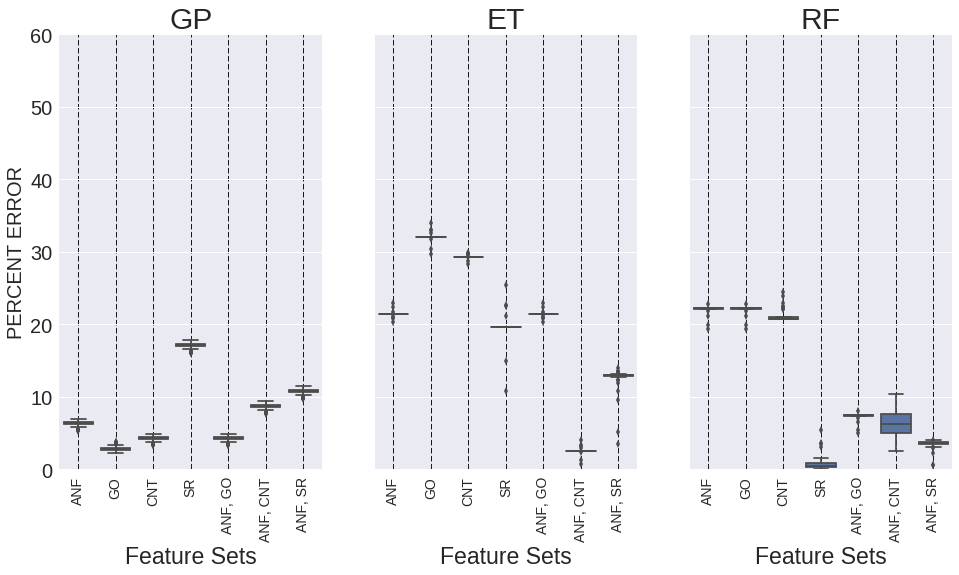

In [39]:
plot_results(best_complete_SR,regressor_,p_type='box',yl=60)

# Analyzing the Analysis
While running the code above, we noticed that the reported errors of each feature-regressor pair are not consistent from analysis to analysis. At this point we are attributing this variability to local minima trapping during the hyperparameter optimization phase of each regression.

In order to better understand the nature of this variability in the results we decided to aggregate the results from 50 iterations of the LOO analyses described above. The results from this aggregate analysis are more inidicative of the error we should expect during the predictive step because it captures the variability due to local minima trapping in the hyperparameter optimization. 

The code for these 50 analyses can be seen below. It is currently commented out because the analysis takes a few hours on a typical desktop or laptop computer.

In [19]:
#super_average_SR = pd.DataFrame()
#super_complete_SR = pd.DataFrame()
#n_tries = 50
#for n in range(n_tries):
#    [summary_listSR, SR_summary_file, complete_listSR, SR_complete_file] = feature_comparison(filename_SR,features_SR,
#                                                        feat_range_SR,C_GO_SR,observ_tag,
#                                                        combined_list,n_tests='LOO_each_')
#    summary_dat_SR = pd.DataFrame(summary_listSR)
#    super_average_SR = pd.concat([super_average_SR,summary_dat_SR])
#    complete_dat_SR = pd.DataFrame(complete_listSR)
#    super_complete_SR = pd.concat([super_complete_SR,complete_dat_SR])
#    pickle.dump(super_average_SR,open(filename_SR[:-4]+'_super_summary_SR'+str(n_tries)+'.p','wb'))
#    pickle.dump(super_complete_SR,open(filename_SR[:-4]+'_super_complete_SR'+str(n_tries)+'.p','wb'))

 The cell below loads an aggregate analysis calculated previously with the code in the above cell.

/home/lukejohnson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


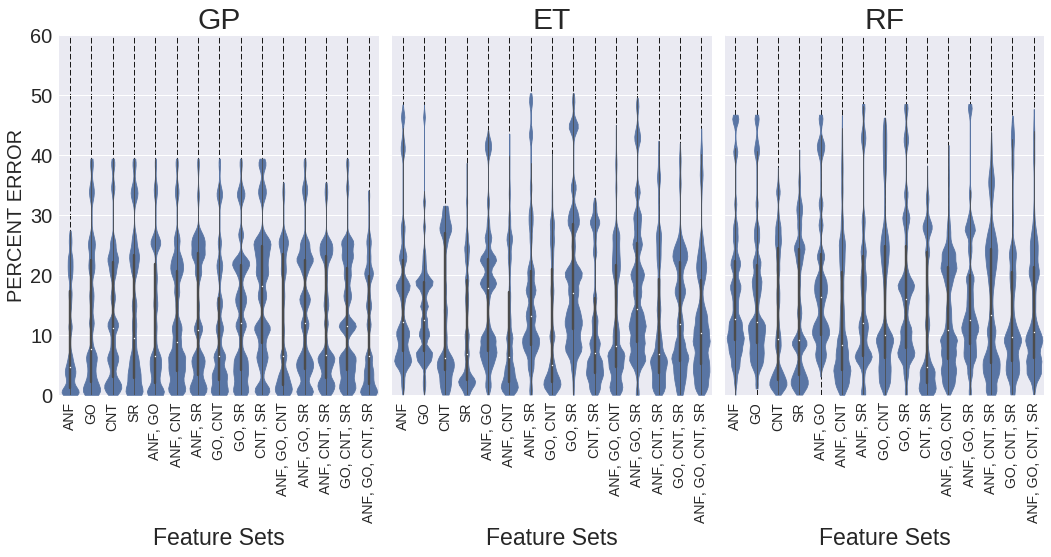

In [37]:
def plot_data_frame(data_frame,error_tag,save=True,p_type='violin',yl=60,filen='total',sublims=[None,None,None,None,None,None]):
    reggie = data_frame.reg_.unique()
    n_reg = len(reggie)
    f, axarr = plt.subplots(1,n_reg,sharey=True,figsize=[16,10])
    pl = 0
    for r in data_frame.reg_.unique():
        this_reg = data_frame[data_frame.reg_ == r]
        if p_type == 'violin':
                axb = sns.violinplot(x='feats',y=error_tag,hue='reg_',data=this_reg,
                                     ax=axarr[pl],inner='box',cut=0,scale='width',bw=0.08,
                                      gridsize=70,linewidth=0.8, scale_hue=False)
        else:
            axb = sns.boxplot(x='feats',y=error_tag,hue='reg_',data=this_reg,ax=axarr[pl])
        for xtick in axb.get_xticklabels():
            xtick.set_rotation(90)
            xtick.set_size(14)
        for ytick in axb.get_yticklabels():
            ytick.set_size(20)
        axb.set_xlabel('Feature Sets',fontsize=23)
        if pl==0:    
            axb.set_ylabel('PERCENT ERROR',fontsize=20)
        else:
            axb.set_ylabel('')
        if yl !=None:
            axb.set_ylim([0,yl])
        axb.set_title(str(reggie[pl]),fontsize=30)
        axb.legend_.remove()
        axb.yaxis.grid(True, which='major')
        axb.xaxis.grid(True,which='major',linestyle='--',color='0.1',linewidth=1)
        pl+=1
    f.subplots_adjust(left=sublims[0], bottom=sublims[1], right=sublims[2], top=sublims[3],
                wspace=sublims[4], hspace=sublims[5])
#    if save==True:
#        f.savefig(filen+'_error.png',dpi=300, facecolor='w', edgecolor='w',
#                    papertype=None, format=None, transparent=False, bbox_inches=None, frameon=None)
    f.show()

super_complete_SR = pickle.load(open(filename_SR[:-4]+'_super_complete_SR50_safe.p','rb'))
super_complete_SR['feats'] = super_complete_SR['feats'].apply(lambda x: ', '.join(x))
super_complete_SR['error_'] = super_complete_SR['error_'].apply(lambda x: 100*x)
plot_data_frame(super_complete_SR,'error_',save=False ,p_type='violin', yl=60, 
                filen='SR50',sublims=[None,0.38,0.98,None,0.04,0.04])
complete_table_SR = pd.pivot_table(super_complete_SR, values='error_', 
                                   index='feats',columns='reg_',aggfunc=[np.mean,len])